###Download and unzip the Crack Dataset consisting of total ~11,200 images, (from 12 different datasets)###

In [1]:
%cd /content/
!cp -f '/content/drive/My Drive/FireVisor/crack_segmentation_dataset.zip' /content

/content


In [2]:
!unzip /content/crack_segmentation_dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: crack_segmentation_dataset/train/masks/Rissbilder_for_Florian_9S6A2817_34_1828_3755_3708.jpg  
  inflating: crack_segmentation_dataset/train/masks/Rissbilder_for_Florian_9S6A2838_547_1340_1856_2398.jpg  
  inflating: crack_segmentation_dataset/train/masks/Volker_DSC01695_806_127_1820_1549.jpg  
  inflating: crack_segmentation_dataset/train/masks/noncrack_noncrack_concrete_wall_12_7.jpg.jpg  
  inflating: crack_segmentation_dataset/train/masks/CRACK500_20160405_171456_1281_361.jpg  
  inflating: crack_segmentation_dataset/train/masks/Volker_DSC01706_240_1123_1495_1323.jpg  
  inflating: crack_segmentation_dataset/train/masks/Rissbilder_for_Florian_9S6A2865_413_845_3382_2544.jpg  
  inflating: crack_segmentation_dataset/train/masks/CRACK500_20160405_171219_1_361.jpg  
  inflating: crack_segmentation_dataset/train/masks/Rissbilder_for_Florian_9S6A2823_571_2290_3080_2668.jpg  
  inflating: crack_segmentation_dataset/train/mask

###Clone Matterport's MASK-RCNN Implementation###

In [3]:
!git clone https://github.com/matterport/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 111.85 MiB | 10.51 MiB/s, done.
Resolving deltas: 100% (563/563), done.


###Clone Assignment repo###

In [4]:

## Need to do from this ...
from getpass import getpass
import os
import urllib

user = getpass('Github user')
password = getpass('Github password')
os.environ['GITHUB_AUTH'] = user + ':' + urllib.parse.quote_plus(password)
#... to this, as the repository is private

!git clone  https://$GITHUB_AUTH@github.com/loong/shubham-fv-test-mask-rcnn.git

Github user··········
Github password··········
Cloning into 'shubham-fv-test-mask-rcnn'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 24 (delta 7), reused 19 (delta 4), pack-reused 0
Unpacking objects: 100% (24/24), done.


#####Switching to Tensorflow 1.x#####

In [1]:
%tensorflow_version 1.x

import tensorflow
print(tensorflow.__version__)
import keras
print(keras.__version__)

TensorFlow 1.x selected.
1.15.2
2.3.1


Using TensorFlow backend.


###Import required libraries/classes, and download MASK-RCNN pre-trained weights on COCO dataset with ResNet-101 backbone###

In [2]:
%cd /content/Mask_RCNN

import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = '/content/drive/My Drive/FireVisor'

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

/content/Mask_RCNN


In [3]:
class CrackConfig(Config):

    # Give the configuration a recognizable name
    NAME = "crack"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 crack (class)

   
    # Our training image size is (448, 448)
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    # Train 64 top ROI's
    TRAIN_ROIS_PER_IMAGE = 64


    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 300  # 300 to get frequent reading from tensorboard, after each epoch

    VALIDATION_STEPS = 50
    
config = CrackConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [4]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [5]:
###Use CrackDataset_with_its_utils.py to get CracksDataset class###
%cd /content/shubham-fv-test-mask-rcnn

from CrackDataset_with_its_utils import CracksDataset

train_dir = '/content/crack_segmentation_dataset/train'
test_dir = '/content/crack_segmentation_dataset/test'

# Training dataset
dataset_train = CracksDataset(utils.Dataset)
dataset_train.load_dataset(train_dir)
dataset_train.prepare()

# Validation dataset
dataset_val = CracksDataset(utils.Dataset)
dataset_val.load_dataset(test_dir)
dataset_val.prepare()

/content/shubham-fv-test-mask-rcnn


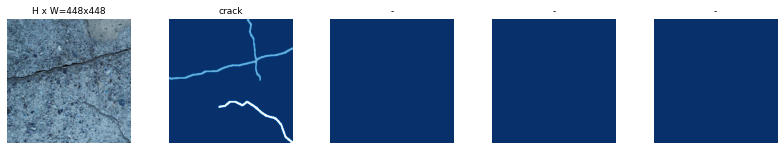

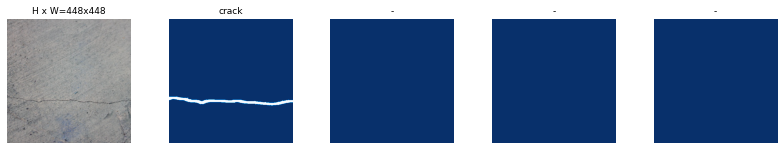

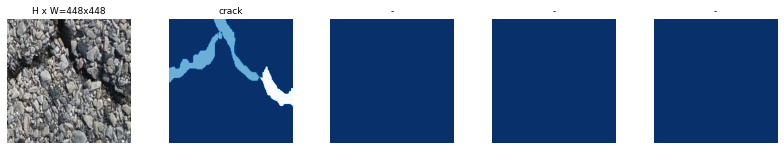

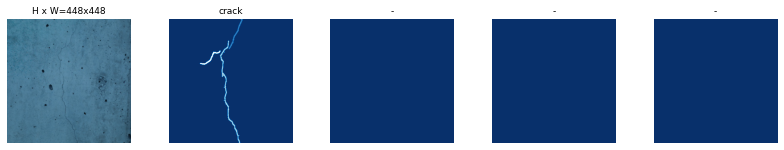

In [6]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [7]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [8]:
## Training stopped in between ##
## So loading the last saved weights ##
model_path = model.find_last()

In [10]:
#model.load_weights(COCO_MODEL_PATH, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])

model.load_weights(model_path, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])

Re-starting from epoch 13


In [11]:
model.keras_model.metrics_tensors = []
tensorboard_callback = tensorflow.keras.callbacks.TensorBoard(MODEL_DIR)

In [12]:
model.train(dataset_train, dataset_val, custom_callbacks = [tensorboard_callback], learning_rate=config.LEARNING_RATE, epochs=25, layers="4+")

# Model trained upto 25 epochs



Starting at epoch 13. LR=0.001

Checkpoint Path: /content/drive/My Drive/FireVisor/logs/crack20200927T1622/mask_rcnn_crack_{epoch:04d}.h5
Selecting layers to train
res4a_branch2a         (Conv2D)
bn4a_branch2a          (BatchNorm)
res4a_branch2b         (Conv2D)
bn4a_branch2b          (BatchNorm)
res4a_branch2c         (Conv2D)
res4a_branch1          (Conv2D)
bn4a_branch2c          (BatchNorm)
bn4a_branch1           (BatchNorm)
res4b_branch2a         (Conv2D)
bn4b_branch2a          (BatchNorm)
res4b_branch2b         (Conv2D)
bn4b_branch2b          (BatchNorm)
res4b_branch2c         (Conv2D)
bn4b_branch2c          (BatchNorm)
res4c_branch2a         (Conv2D)
bn4c_branch2a          (BatchNorm)
res4c_branch2b         (Conv2D)
bn4c_branch2b          (BatchNorm)
res4c_branch2c         (Conv2D)
bn4c_branch2c          (BatchNorm)
res4d_branch2a         (Conv2D)
bn4d_branch2a          (BatchNorm)
res4d_branch2b         (Conv2D)
bn4d_branch2b          (BatchNorm)
res4d_branch2c         (Conv2D)

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/tensorflow-1.15.2/python3.6/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 14/30
300/300 [==============================] - 395s 1s/step - loss: 1.2344 - val_loss: 1.6252

Epoch 15/30
300/300 [==============================] - 357s 1s/step - loss: 1.1017 - val_loss: 1.3005
Epoch 16/30
300/300 [==============================] - 357s 1s/step - loss: 1.0498 - val_loss: 1.2516
Epoch 17/30
300/300 [==============================] - 357s 1s/step - loss: 1.0356 - val_loss: 1.5190
Epoch 18/30
300/300 [==============================] - 357s 1s/step - loss: 1.0605 - val_loss: 1.1457
Epoch 19/30
300/300 [==============================] - 358s 1s/step - loss: 1.0165 - val_loss: 1.4698
Epoch 20/30
300/300 [==============================] - 356s 1s/step - loss: 1.0184 - val_loss: 1.5541
Epoch 21/30
300/300 [==============================] - 357s 1s/step - loss: 0.9296 - val_loss: 2.0429
Epoch 22/30
300/300 [==============================] - 357s 1s/step - loss: 0.9636 - val_loss: 1.0502
Epoch 23/30
300/300 [==============================] - 356s 1s/step - loss: 0.966

Process ForkPoolWorker-3:
Process ForkPoolWorker-4:
Process ForkPoolWorker-1:
Process ForkPoolWorker-2:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process

KeyboardInterrupt: ignored

In [13]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [14]:
%tensorboard --logdir '/content/drive/My Drive/FireVisor/logs/crack20200927T1622'

###Do the inference###

In [40]:
class InferenceConfig(CrackConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.8

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /content/drive/My Drive/FireVisor/logs/crack20200927T1622/mask_rcnn_crack_0025.h5
Re-starting from epoch 25


##Sample Images##

####Sample Image -1####

original_image           shape: (256, 256, 3)         min:   25.00000  max:  223.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 1083.00000  float64
gt_class_id              shape: (2,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (2, 4)                min:    0.00000  max:  256.00000  int32
gt_mask                  shape: (256, 256, 2)         min:    0.00000  max:    1.00000  uint8


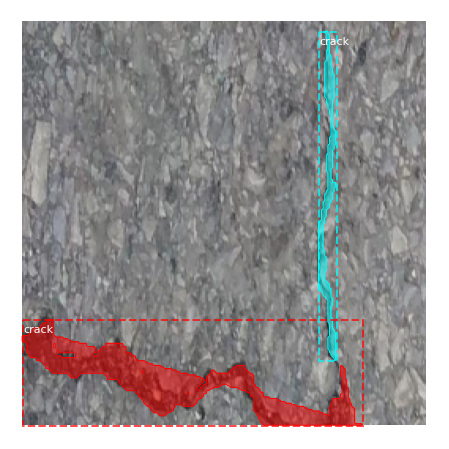

In [59]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (256, 256, 3)         min:   25.00000  max:  223.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min:  -98.70000  max:  119.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32


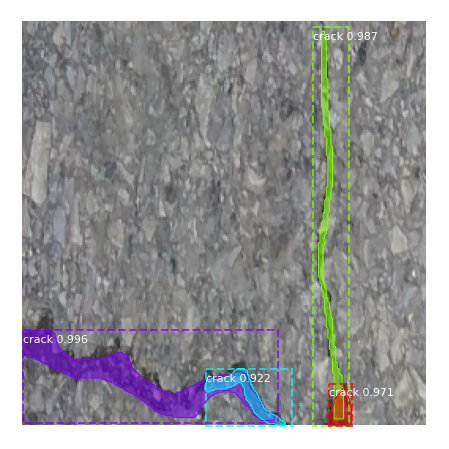

In [60]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

####Sample Image -2####

original_image           shape: (256, 256, 3)         min:    5.00000  max:  247.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 1082.00000  float64
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:    0.00000  max:  256.00000  int32
gt_mask                  shape: (256, 256, 1)         min:    0.00000  max:    1.00000  uint8


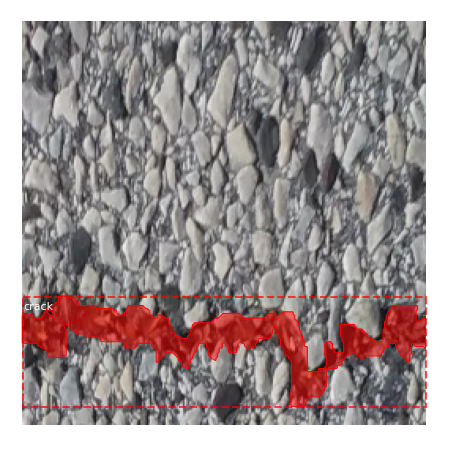

In [53]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  247.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -114.70000  max:  143.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32


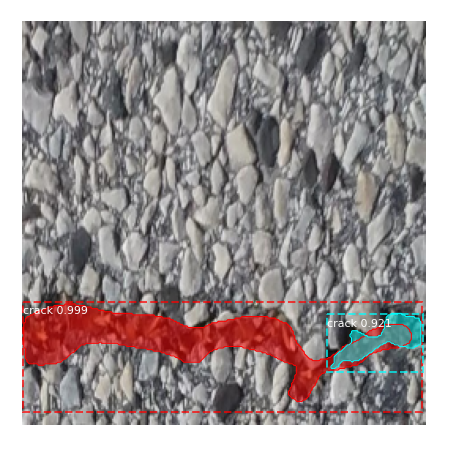

In [54]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

####Sample Image -3####

original_image           shape: (256, 256, 3)         min:    3.00000  max:  172.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 1379.00000  float64
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:    0.00000  max:  256.00000  int32
gt_mask                  shape: (256, 256, 1)         min:    0.00000  max:    1.00000  uint8


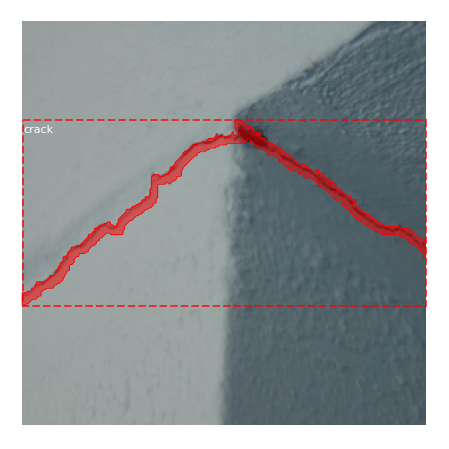

In [47]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  172.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -120.70000  max:   68.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32


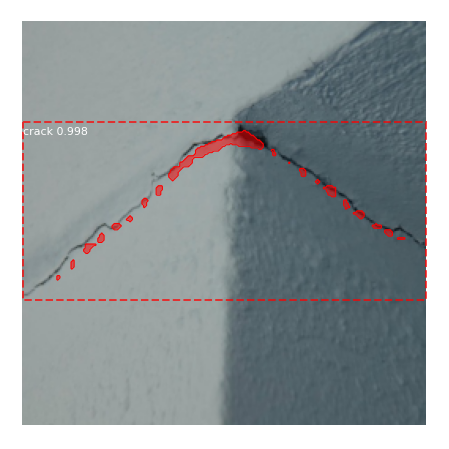

In [48]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [64]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 500 images. 
image_ids = np.random.choice(dataset_val.image_ids, 500)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.20445555592775344


###Model is trained for just 25 epochs with each epoch just containing 300 steps, and this problem of crack segmentation is very different from commnon problems in which we have fixed/defined boundaries###